<a href="https://colab.research.google.com/github/solanki1993/Covid19-detection-using-ct-scan-and-chest-x-rays-with-DL/blob/main/COVID_19_Detection_InceptionV3_CT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing dependencies

from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

In [ ]:
IMAGE_SIZE = [224, 224]

epochs = 500
batch_size = 32

covid_path = '/content/drive/MyDrive/data and models/data/ct/CT_COVID'
noncovid_path = '/content/drive/MyDrive/data and models/data/ct/CT_NonCOVID'

covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [ ]:
print("First 5 Covid Files: ",covid_files[0:5])
print("Total Count: ",len(covid_files))
print("First 5 NonCovid Files: ",noncovid_files[0:5])
print("Total Count: ",len(noncovid_files))

First 5 Covid Files:  ['/content/drive/MyDrive/data and models/data/ct/CT_COVID/2020.03.04.20026005-p12-1946_5.png', '/content/drive/MyDrive/data and models/data/ct/CT_COVID/2020.03.03.20030775-p12-93_1.png', '/content/drive/MyDrive/data and models/data/ct/CT_COVID/2020.03.11.20033159-p12-45_5.png', '/content/drive/MyDrive/data and models/data/ct/CT_COVID/2020.03.04.20031047-p12-81_2.png', '/content/drive/MyDrive/data and models/data/ct/CT_COVID/2020.03.04.20031039-p23-97_2_2.png']
Total Count:  349
First 5 NonCovid Files:  ['/content/drive/MyDrive/data and models/data/ct/CT_NonCOVID/921.png', '/content/drive/MyDrive/data and models/data/ct/CT_NonCOVID/663.png', '/content/drive/MyDrive/data and models/data/ct/CT_NonCOVID/709.png', '/content/drive/MyDrive/data and models/data/ct/CT_NonCOVID/782.png', '/content/drive/MyDrive/data and models/data/ct/CT_NonCOVID/781.png']
Total Count:  397


In [ ]:
# Fetch Images and Class Labels from Files



covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i]) # read file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per kera
  image = cv2.resize(image,(224,224)) # resize as per model
  covid_images.append(image) # append image
  covid_labels.append('CT_COVID') # append class label
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('CT_NonCOVID')

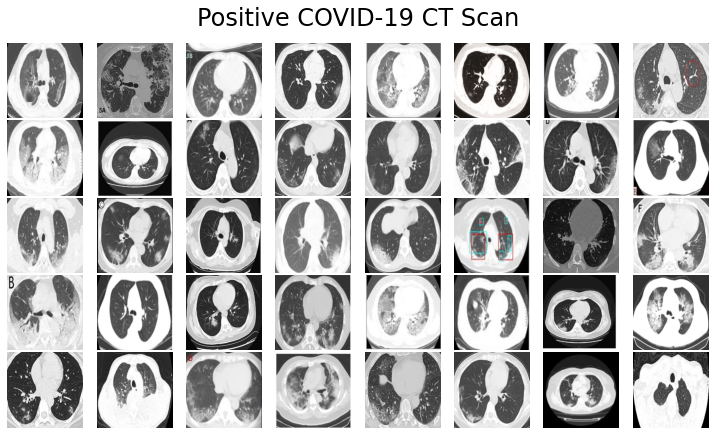

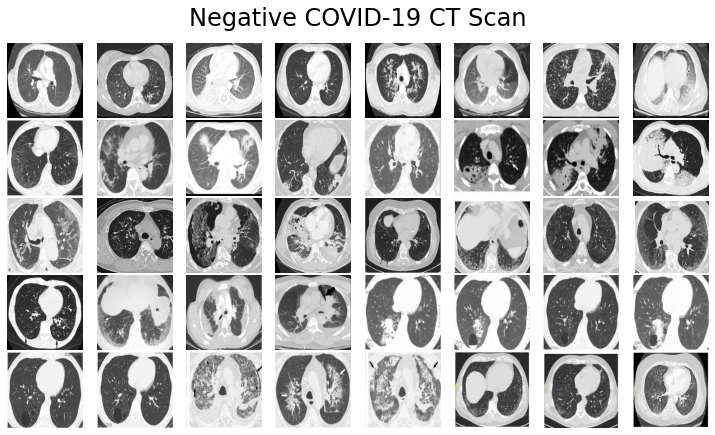

In [ ]:
#visualising first 40 images from dataset

def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 CT Scan')
plot_images(noncovid_images, 'Negative COVID-19 CT Scan')


In [ ]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

In [ ]:
# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

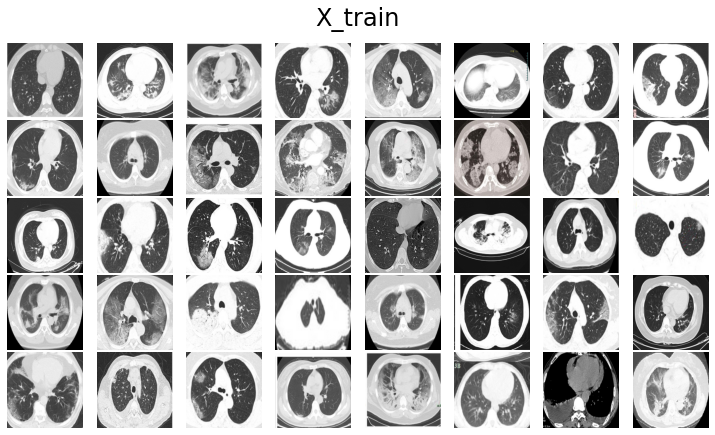

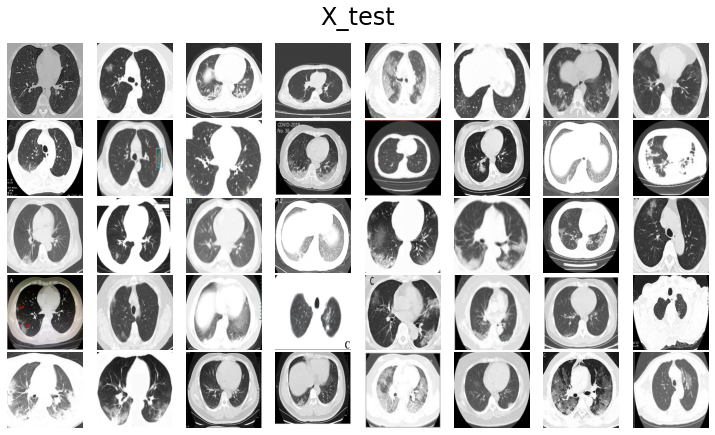

In [ ]:
#Visualize a few images from Training and Test sets

plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')

In [ ]:
#Building and Visualizing model

inception = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
#To train on images at different positions, angles, flips, etc- IMage augmentation

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [ ]:
#training the model

history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/500
18/18 [==============================] - 27s 677ms/step - loss: 6.4119 - accuracy: 0.5352 - val_loss: 1.6436 - val_accuracy: 0.6733
Epoch 2/500
18/18 [==============================] - 8s 457ms/step - loss: 2.2361 - accuracy: 0.6795 - val_loss: 2.0712 - val_accuracy: 0.6333
Epoch 3/500
18/18 [==============================] - 8s 447ms/step - loss: 1.2502 - accuracy: 0.7282 - val_loss: 0.7910 - val_accuracy: 0.7467
Epoch 4/500
18/18 [==============================] - 8s 447ms/step - loss: 1.1879 - accuracy: 0.7282 - val_loss: 1.2239 - val_accuracy: 0.7333
Epoch 5/500
18/18 [==============================] - 8s 446ms/step - loss: 1.1689 - accuracy: 0.7232 - val_loss: 1.2426 - val_accuracy: 0.7267
Epoch 6/500
18/18 [==============================] - 8s 445ms/step - loss: 1.0133 - accuracy: 0.7534 - val_loss: 1.1406 - val_accuracy: 0.7133
Epoch 7/500
18/18 [==============================] - 8s 447ms/step - loss: 1.2699 - accuracy: 0.7534 - val_loss: 1.9626 - val_accuracy: 0.673

In [ ]:
model.save('inception_ct.h5')
model.save_weights('inception_weights_ct.hdf5')

In [ ]:
# Load saved model
model = load_model('inception_ct.h5')

In [ ]:
#Making Predicions

y_pred = model.predict(X_test, batch_size=batch_size)

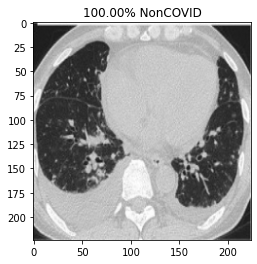

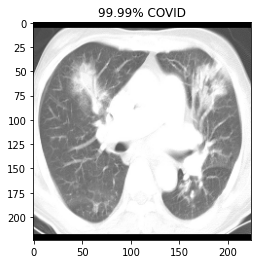

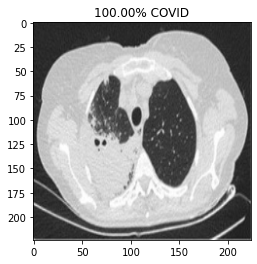

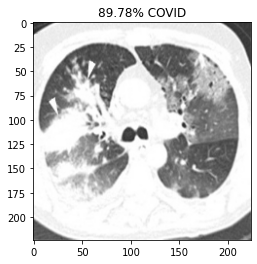

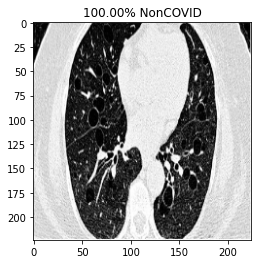

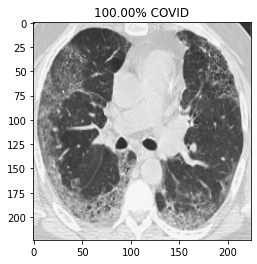

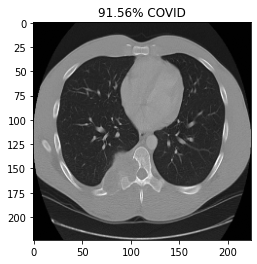

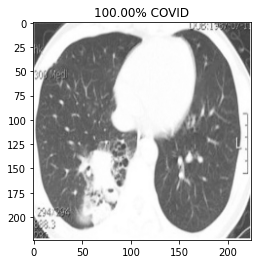

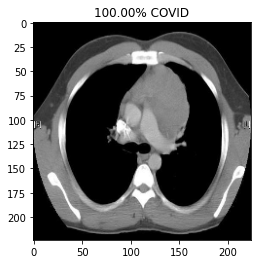

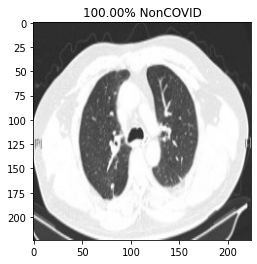

In [ ]:
#Visulaizing First 10 predictions

prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.style.reload_library
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

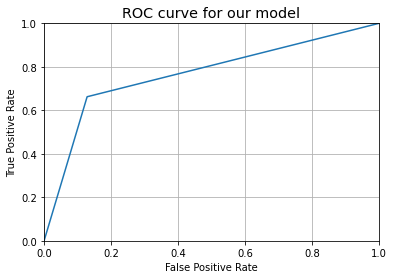

In [ ]:
#Plotting ROC Curve

fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)


Confusion Matrix without Normalization


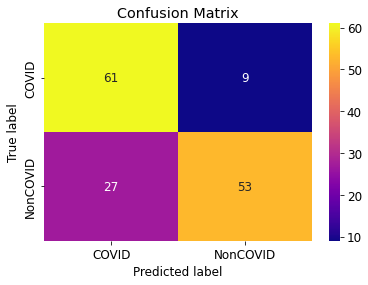

Confusion Matrix with Normalized Values


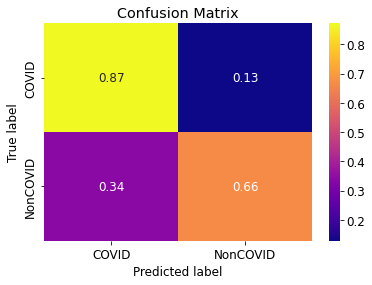

In [ ]:
#Plotting Confusion Matrix

def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [ ]:
#Classification Report

from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.69      0.87      0.77        70
           1       0.85      0.66      0.75        80

    accuracy                           0.76       150
   macro avg       0.77      0.77      0.76       150
weighted avg       0.78      0.76      0.76       150



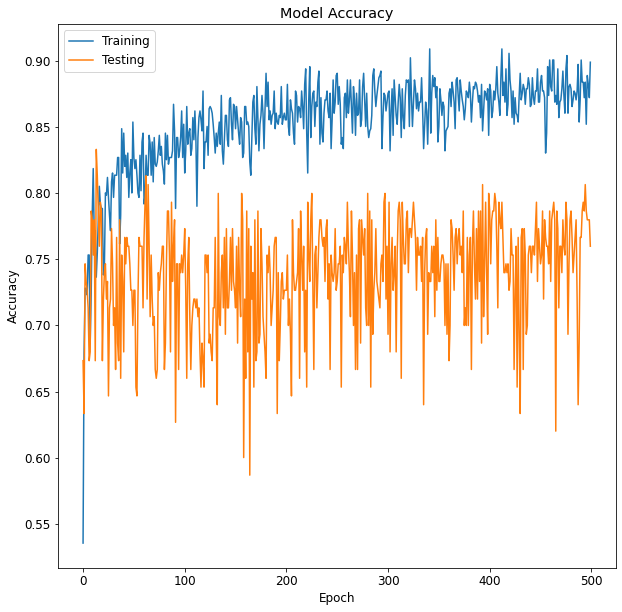

In [ ]:
#Accuracy and Loss Plots

plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_ct_accuracy.png')
plt.show()

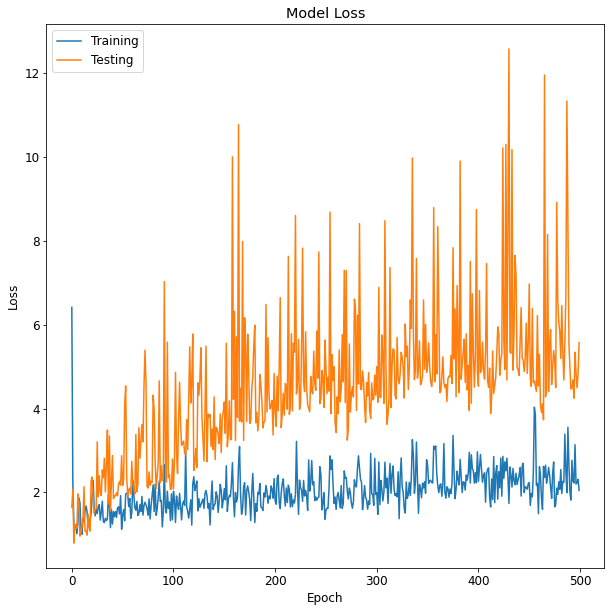

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_ct_loss.png')
plt.show()